In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
from fastai.vision import *
from fastai.metrics import error_rate

torch.manual_seed(121)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(121)

In [3]:
df = pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
labels = np.array(df.iloc[:, 1:])
labels = np.where(labels==1)[1]

df['label'] = labels
df.to_csv('./train_data.csv', index=False)

In [4]:
BS = 4
IMG_SZ = 768
GPU_IDS = [0,2]
torch.cuda.set_device(0)
CLASS_WT = torch.FloatTensor([1.0, 1.0, 1.0, 1.0]).to('cuda:'+str(GPU_IDS[0]))

label_dict = {0: 'healthy',
              1: 'multiple_diseases',
              2: 'rust',
              3: 'scab',
              'micro': 'micro',
              'macro': 'macro',
             }

In [ ]:
# get_transforms??

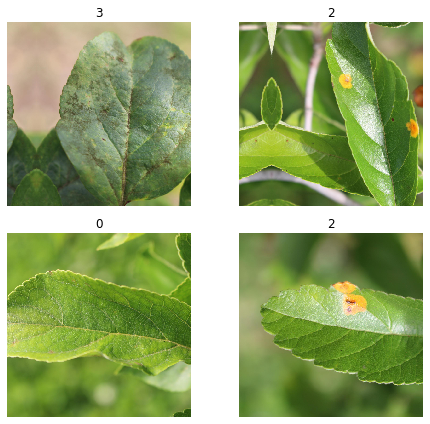

In [5]:
data_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=None)

data = ImageDataBunch.from_csv('../input/plant-pathology-2020-fgvc7', csv_labels='../../working/train_data.csv', folder='images', 
                               label_col=5, suffix='.jpg', valid_pct=0.15, ds_tfms=data_tfms, seed=0,
                               bs=BS, size=IMG_SZ).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,6))

In [ ]:
# weights = 1+(data.train_ds.y.items == 1)

# wtd_sampler = torch.utils.data.WeightedRandomSampler(weights, weights.shape[0], replacement=True)
# data.train_dl = data.train_dl.new(shuffle=False, sampler=wtd_sampler)

In [6]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
class AUC(Callback):

    def __init__(self, num_cl, pick='micro'):
        self.id_to_class = label_dict
        self.name = str(self.id_to_class[pick])+'-AUC'
        self.pick = pick
        self.num_cl = num_cl
        
    
    def on_epoch_begin(self, **kwargs):
        self.outputs, self.targets = [], []
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.outputs.append(last_output)
        self.targets.append(last_target)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        self.outputs = F.softmax(torch.cat(self.outputs), dim=1).cpu().detach().numpy()
        self.targets = torch.cat(self.targets).cpu().numpy().reshape(-1)
        self.targets = np.eye(self.num_cl)[self.targets]
        fpr, tpr, roc_auc = {}, {}, {'macro':0}
        for i in range(self.num_cl):
            roc_auc[self.id_to_class[i]] = roc_auc_score(self.targets[:, i], self.outputs[:, i])
            roc_auc['macro'] += roc_auc[self.id_to_class[i]]
        roc_auc['micro'] = roc_auc_score(self.targets.ravel(), self.outputs.ravel())
        roc_auc['macro'] = roc_auc['macro']/self.num_cl
#           fpr[i], tpr[i], _ = roc_curve(self.targets[:, i], self.outputs[:, i])
    
        
#         # Compute micro-average ROC curve and ROC area
#         fpr["micro"], tpr["micro"], _ = roc_curve(self.targets.ravel(), self.outputs.ravel())
#         roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#         all_fpr = np.unique(np.concatenate([fpr[i] for i in range(self.num_cl)]))

#         # Then interpolate all ROC curves at this points
#         mean_tpr = np.zeros_like(all_fpr)
#         for i in range(self.num_cl):
#             mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#         # Finally average it and compute AUC
#         mean_tpr /= self.num_cl

#         fpr["macro"] = all_fpr
#         tpr["macro"] = mean_tpr
#         roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        return add_metrics(last_metrics, roc_auc[self.id_to_class[self.pick]])


In [10]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b5'
def getModel():
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(2048,data.c)
    return model

In [11]:
learn = Learner(data, getModel(), model_dir='../models/',
                    metrics=[accuracy, AUC(num_cl=4, pick=0), AUC(num_cl=4, pick=1), AUC(num_cl=4, pick=2), AUC(num_cl=4, pick=3), AUC(num_cl=4, pick='macro')])
learn.loss_func = nn.CrossEntropyLoss(weight=CLASS_WT)

learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)

Loaded pretrained weights for efficientnet-b5


In [ ]:
# preds,y,losses = learn.get_preds(with_loss=True)
# interp = ClassificationInterpretation(learn, preds, y, losses)
# interp.plot_top_losses(9, figsize=(15,11))
# interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

epoch,train_loss,valid_loss,accuracy,healthy-AUC,multiple_diseases-AUC,rust-AUC,scab-AUC,macro-AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


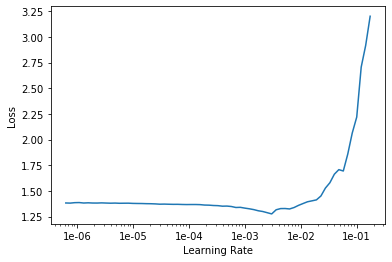

In [12]:
# learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,healthy-AUC,multiple_diseases-AUC,rust-AUC,scab-AUC,macro-AUC,time
0,0.670782,0.423195,0.882784,0.974932,0.739106,0.961163,0.988320,0.915880,03:15
1,0.340827,0.255308,0.926740,0.994795,0.856591,0.995182,0.990978,0.959386,03:12
2,0.307850,0.245355,0.937729,0.990342,0.813569,0.996169,0.986899,0.946745,03:17
3,0.173498,0.328134,0.901099,0.992123,0.804192,0.997097,0.986652,0.945016,03:19
4,0.118635,0.139910,0.956044,0.997877,0.941258,0.997794,0.998331,0.983815,03:20
5,0.148665,0.147214,0.956044,0.997945,0.946222,0.998839,0.998517,0.985381,03:17


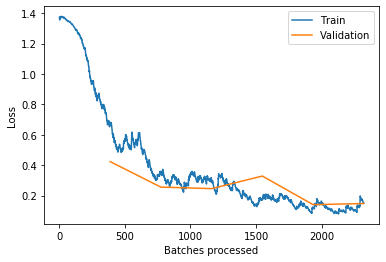

In [13]:
learn.fit_one_cycle(6, max_lr=3*1e-4)
learn.recorder.plot_losses()
learn.save('efn-B5-stage-1')

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,healthy-AUC,multiple_diseases-AUC,rust-AUC,scab-AUC,macro-AUC,time


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=3*1e-6)
learn.recorder.plot_losses()
learn.save('efn-B5-stage-2')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.load('efn-B5-stage-2')
learn.validate(data.valid_dl)

In [ ]:
test_df = pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')

In [ ]:
test = ImageList.from_df(test_df, '../input/plant-pathology-2020-fgvc7/images/', suffix='.jpg')
data.add_test(test)
print(data)

In [ ]:
preds, *_ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
sub = pd.read_csv('../input/plant-pathology-2020-fgvc7/sample_submission.csv')
for lbl in range(4): 
    sub[[label_dict[lbl]]] = preds.detach().numpy()[:, lbl]
sub.head

In [ ]:
sub.to_csv('submission.csv', index=False)